# BYOK Benchmarking: RSA vs Kyber

This notebook benchmarks Bring Your Own Key (BYOK) operations for RSA and Post-Quantum Cryptography (PQC) Kyber algorithms.

## Scenario
- Encrypt 10 datasets using 10 different AES symmetric keys.
- Use 1 Kyber key pair to encapsulate all 10 AES keys.
- Use 10 RSA key pairs to encrypt each AES key respectively (simulate key rotation).
- Measure and compare key generation times, encryption times, decryption times.
- Compare total RSA key sizes vs Kyber public key size.
- Plot the results to illustrate performance and size differences.

This tutorial-style notebook demonstrates Kyber's efficiency advantages over RSA for BYOK in cloud/enterprise use cases.

### Install required libraries

```pip install -r requirements.txt```


In [1]:
import time
import matplotlib.pyplot as plt
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP, AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad, unpad
from kyber_py.kyber import Kyber512

### AES Encryption and Decryption Functions

In [2]:
def aes_encrypt(data, key):
    cipher = AES.new(key, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(data, AES.block_size))
    return ct_bytes, cipher.iv

def aes_decrypt(ct_bytes, iv, key):
    cipher = AES.new(key, AES.MODE_CBC, iv)
    return unpad(cipher.decrypt(ct_bytes), AES.block_size)

### Generate RSA Keys with Rotation (10 keys)

In [3]:
def generate_rsa_keys(num_keys=10):
    keys = []
    start = time.time()
    for _ in range(num_keys):
        key = RSA.generate(2048)
        keys.append(key)
    end = time.time()
    return keys, end - start

### RSA Encryption and Decryption of AES Keys

In [4]:
def rsa_enc_dec(keys, aes_keys):
    enc_times, dec_times = [], []
    for i in range(len(aes_keys)):
        rsa_pub = PKCS1_OAEP.new(keys[i].publickey())
        start = time.time()
        encrypted_key = rsa_pub.encrypt(aes_keys[i])
        enc_times.append(time.time()-start)

        rsa_priv = PKCS1_OAEP.new(keys[i])
        start = time.time()
        decrypted_key = rsa_priv.decrypt(encrypted_key)
        dec_times.append(time.time()-start)
    return sum(enc_times), sum(dec_times)

### Kyber Single Key Generation and Encapsulation/Decapsulation of AES Keys

In [5]:
def kyber_enc_dec(aes_keys):
    start_keygen = time.time()
    public_key, private_key = Kyber512.keygen()
    keygen_time = time.time() - start_keygen

    start_encap = time.time()
    sym_key, ciphertext = Kyber512.encaps(public_key)  # Single encaps for demo
    encap_time = time.time() - start_encap

    start_decap = time.time()
    dec_sym_key = Kyber512.decaps(private_key, ciphertext)
    decap_time = time.time() - start_decap

    return keygen_time, encap_time, decap_time, public_key, private_key

### Benchmark RSA and Kyber BYOK Operations

In [6]:
def benchmark():
    import matplotlib.pyplot as plt
    # Magic command to render plots inline (put this in the first cell)
    try:
        get_ipython().run_line_magic('matplotlib', 'inline')
    except:
        pass

    # Create 10 sample datasets
    datasets = [f"Sample data for BYOK - set {i}".encode() for i in range(10)]
    for i in range(10):
        datasets[i] = datasets[i] * 100  # Increase size for better benchmarking

    # Generate 10 AES keys (AES-128 keys are 16 bytes)
    aes_keys = [get_random_bytes(16) for _ in range(10)]

    # Encrypt each dataset with its AES key and measure time
    encrypted_datasets = []
    iv_list = []
    aes_enc_times = []
    for i in range(10):
        start = time.time()
        ct, iv = aes_encrypt(datasets[i], aes_keys[i])
        elapsed = time.time() - start
        aes_enc_times.append(elapsed)
        encrypted_datasets.append(ct)
        iv_list.append(iv)
    total_aes_enc_time = sum(aes_enc_times)

    # RSA metrics
    rsa_keys, rsa_keygen_time = generate_rsa_keys(10)
    rsa_enc_time, rsa_dec_time = rsa_enc_dec(rsa_keys, aes_keys)
    rsa_total_key_size = sum([key.size_in_bytes() for key in rsa_keys])

    # Kyber metrics
    kyber_keygen_time, kyber_enc_time, kyber_dec_time, kyber_pub, kyber_priv = kyber_enc_dec(aes_keys)
    kyber_pub_key_size = len(kyber_pub)

    # Simulate Kyber decapsulation per AES key
    total_kyber_dec_time = kyber_dec_time * 10

    # Total times including AES dataset encryption time
    total_rsa_time = rsa_keygen_time + rsa_enc_time + rsa_dec_time + total_aes_enc_time
    total_kyber_time = kyber_keygen_time + kyber_enc_time + total_kyber_dec_time + total_aes_enc_time

    # Print summary
    print(f"RSA Total KeyGen Time (10 keys): {rsa_keygen_time:.4f} s")
    print(f"RSA Total Encryption Time for 10 AES keys: {rsa_enc_time:.4f} s")
    print(f"RSA Total Decryption Time for 10 AES keys: {rsa_dec_time:.4f} s")
    print(f"Sum of RSA Key Sizes: {rsa_total_key_size} bytes")
    print(f"Kyber KeyGen Time: {kyber_keygen_time:.4f} s")
    print(f"Kyber Encapsulation Time: {kyber_enc_time:.4f} s")
    print(f"Kyber Decapsulation Time * 10: {total_kyber_dec_time:.4f} s")
    print(f"Kyber Public Key Size: {kyber_pub_key_size} bytes")
    print(f"Total AES Data Encryption Time: {total_aes_enc_time:.4f} s")
    print(f"Total RSA Time (KeyGen + Enc + Dec + AES Enc): {total_rsa_time:.4f} s")
    print(f"Total Kyber Time (KeyGen + Enc + Dec x10 + AES Enc): {total_kyber_time:.4f} s")

    # Plot 1: Key Size Comparison
    plt.figure(figsize=(8,5))
    plt.bar(['Kyber Public Key', 'Sum of RSA Keys'], [kyber_pub_key_size, rsa_total_key_size], color=['green', 'blue'])
    plt.ylabel('Key Size (Bytes)')
    plt.title('Key Size Comparison: Kyber vs RSA')
    plt.grid(axis='y')
    plt.show()

    # Plot 2: Key Generation Time Comparison
    plt.figure(figsize=(8,5))
    plt.bar(['Kyber (1 key)', 'RSA (10 keys)'], [kyber_keygen_time, rsa_keygen_time], color=['green', 'blue'])
    plt.ylabel('Time (Seconds)')
    plt.title('Key Generation Time: Kyber vs RSA')
    plt.grid(axis='y')
    plt.show()

    # Plot 3: Encryption Time Comparison (AES key encryption)
    plt.figure(figsize=(8,5))
    plt.bar(['Kyber (Encapsulation)', 'RSA (Encryption)'], [kyber_enc_time, rsa_enc_time], color=['green', 'blue'])
    plt.ylabel('Time (Seconds)')
    plt.title('AES Key Encryption Time: Kyber vs RSA')
    plt.grid(axis='y')
    plt.show()

    # Plot 4: Total Time Comparison (Kyber for each dataset vs RSA total)
    plt.figure(figsize=(8,5))
    plt.bar(['Kyber Total (x10 Decaps + AES Enc)', 'RSA Total + AES Enc'], [total_kyber_time, total_rsa_time], color=['green', 'blue'])
    plt.ylabel('Time (Seconds)')
    plt.title('Total BYOK Operation Time Comparison: Kyber vs RSA')
    plt.grid(axis='y')
    plt.show()

    return {
  "kyber_pub_key_size": kyber_pub_key_size,
  "rsa_total_key_size": rsa_total_key_size,
  "kyber_keygen_time": kyber_keygen_time,
  "rsa_keygen_time": rsa_keygen_time,
  "kyber_enc_time": kyber_enc_time,
  "rsa_enc_time": rsa_enc_time,
  "total_kyber_time": total_kyber_time,
  "total_rsa_time": total_rsa_time
}


RSA Total KeyGen Time (10 keys): 10.1515 s
RSA Total Encryption Time for 10 AES keys: 0.0058 s
RSA Total Decryption Time for 10 AES keys: 0.0283 s
Sum of RSA Key Sizes: 2560 bytes
Kyber KeyGen Time: 0.0049 s
Kyber Encapsulation Time: 0.0021 s
Kyber Decapsulation Time * 10: 0.0404 s
Kyber Public Key Size: 800 bytes
Total AES Data Encryption Time: 0.0041 s
Total RSA Time (KeyGen + Enc + Dec + AES Enc): 10.1897 s
Total Kyber Time (KeyGen + Enc + Dec x10 + AES Enc): 0.0516 s


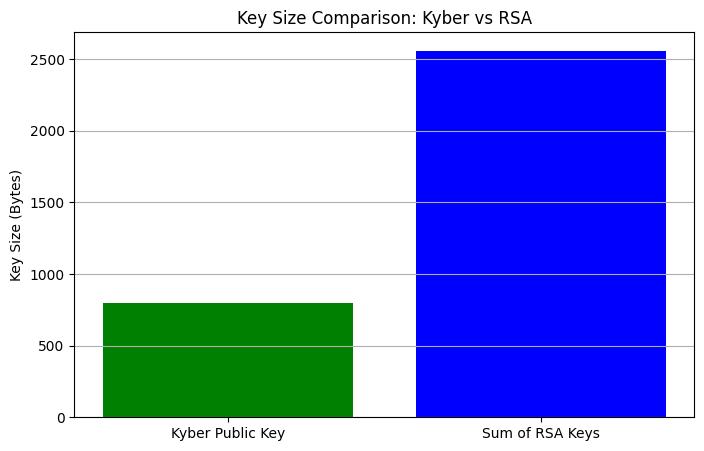

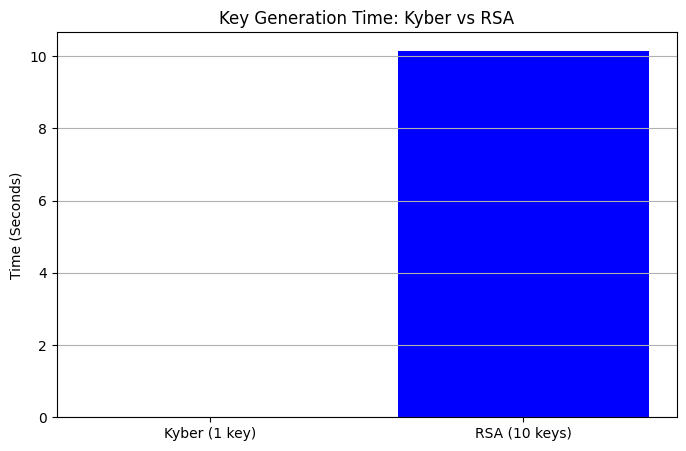

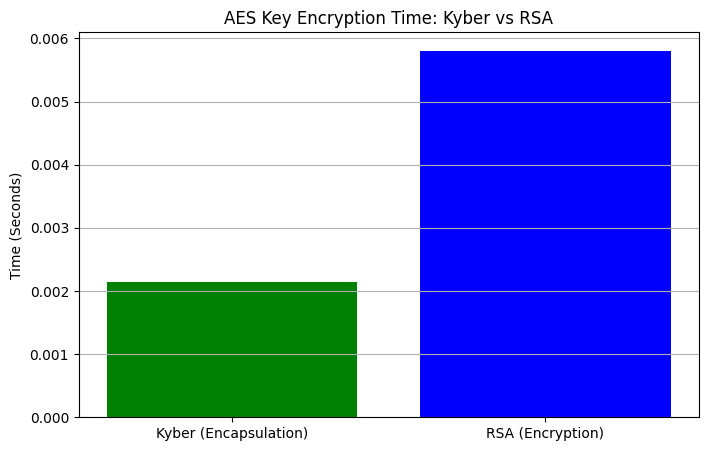

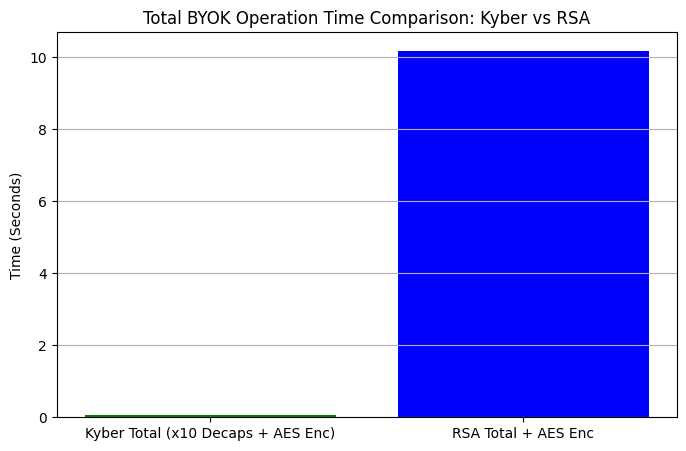

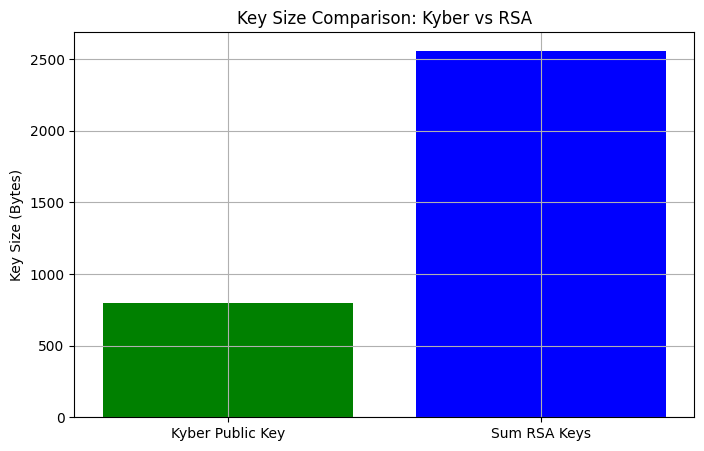

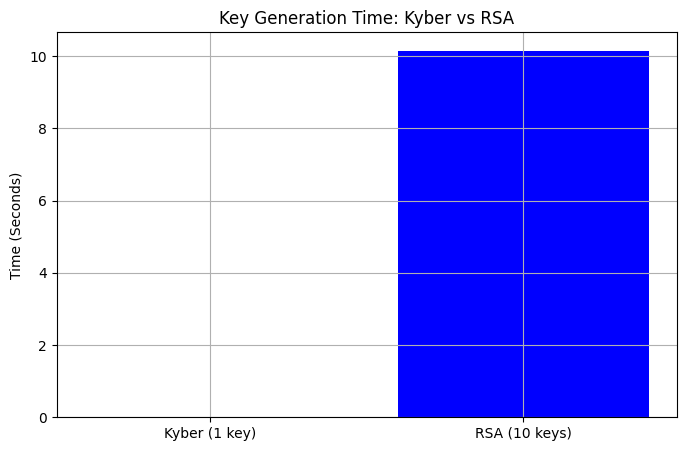

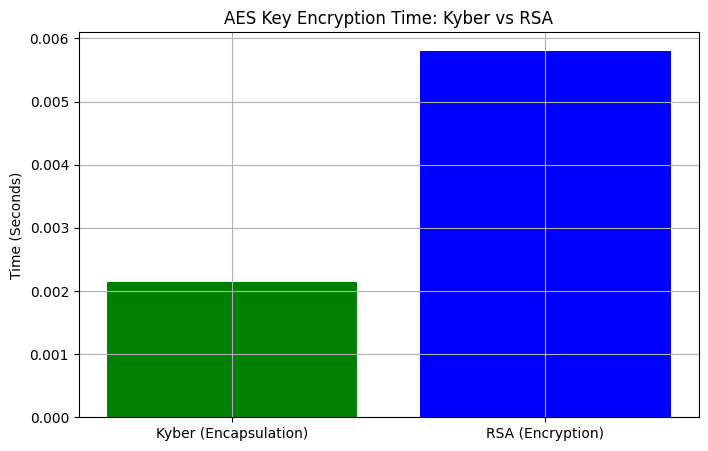

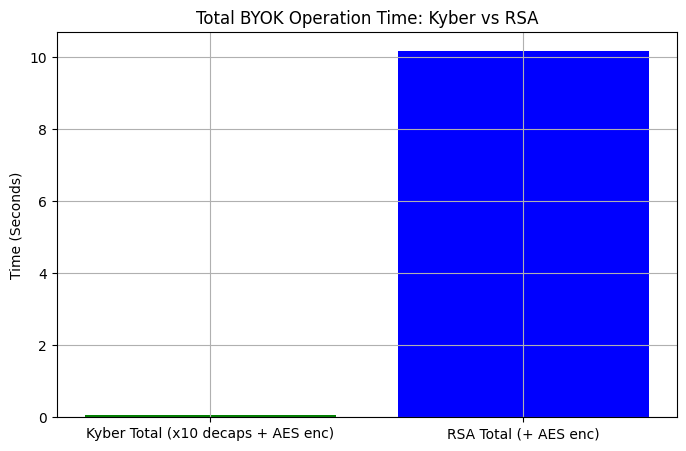

In [8]:
metrics = benchmark()
import matplotlib.pyplot as plt

# Plot total key size comparison
plt.figure(figsize=(8,5))
plt.bar(['Kyber Public Key', 'Sum RSA Keys'],
        [metrics["kyber_pub_key_size"], metrics["rsa_total_key_size"]], color=['green', 'blue'])
plt.ylabel('Key Size (Bytes)')
plt.title('Key Size Comparison: Kyber vs RSA')
plt.grid(True)
plt.show()

# Plot key generation time comparison
plt.figure(figsize=(8,5))
plt.bar(['Kyber (1 key)', 'RSA (10 keys)'],
        [metrics["kyber_keygen_time"], metrics["rsa_keygen_time"]], color=['green', 'blue'])
plt.ylabel('Time (Seconds)')
plt.title('Key Generation Time: Kyber vs RSA')
plt.grid(True)
plt.show()

# Plot AES key encapsulation/encryption time comparison
plt.figure(figsize=(8,5))
plt.bar(['Kyber (Encapsulation)', 'RSA (Encryption)'],
        [metrics["kyber_enc_time"], metrics["rsa_enc_time"]], color=['green', 'blue'])
plt.ylabel('Time (Seconds)')
plt.title('AES Key Encryption Time: Kyber vs RSA')
plt.grid(True)
plt.show()

# Plot total BYOK operation time comparison
plt.figure(figsize=(8,5))
plt.bar(['Kyber Total (x10 decaps + AES enc)', 'RSA Total (+ AES enc)'],
        [metrics["total_kyber_time"], metrics["total_rsa_time"]], color=['green', 'blue'])
plt.ylabel('Time (Seconds)')
plt.title('Total BYOK Operation Time: Kyber vs RSA')
plt.grid(True)
plt.show()
